# NLP Methods for Text Classification

In [25]:
import warnings; warnings.simplefilter("ignore")
import nltk
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from livelossplot import PlotLossesKeras
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, Dropout, Flatten, Activation, Conv1D, MaxPooling1D, BatchNormalization, Bidirectional

from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.utils import resample

In [45]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/latra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/latra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/latra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
pd.options.display.max_seq_items = 100
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', 200)
np.set_printoptions(threshold=np.inf)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

EMBEDDING_LENGTH = 300

<Figure size 1332x756 with 0 Axes>

### Classes and helper functions

In [3]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        
    def fit(self, X, y):
        return self 

    def transform(self, X):
        retVal = []
        for line in X:
            temp = np.array(np.mean([self.word2vec[w] for w in line.split() if w in self.word2vec] 
                                or [np.zeros(EMBEDDING_LENGTH)], axis=0))
            retVal.append(temp)
        return retVal

In [4]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

In [5]:
# create input volume for RNN with output shape [samples, timesteps, features]
def input_volume(model, word_list, timesteps):
    w2v = np.zeros([len(word_list), timesteps, EMBEDDING_LENGTH])
    c1 = 0
    for word in word_list:
        x = np.zeros([timesteps, EMBEDDING_LENGTH])
        if type(word) == list:
            c2 = 0
            for i, w in enumerate(word):
                if i < timesteps:
                    try: 
                        x[c2] = model[w]
                        c2 += 1
                    except KeyError:
                        pass
        elif type(word) == str:
            x[0] = model[word]
        w2v[c1] = x
        c1 += 1
    return w2v

In [8]:
# from https://scikit-learn.org/stable/_downloads/plot_confusion_matrix.py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 


In [9]:
# create additional "class" column with encoded label 
def encode_label(df, label):
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(df[label].unique())
    df["class"] = label_encoder.transform(df[label])
    return df

In [23]:
def get_df_using_threshold(df, column, threshold):
    values = df[column].value_counts().keys().tolist()
    count_df = df[column].value_counts().to_frame()
    high_occurence_df = count_df[count_df[column].values >= threshold]
    high_occurence_vals = high_occurence_df.index.tolist()
    final_df = df.loc[df[column].isin(high_occurence_vals)]
    return final_df

## Read data and preprocess text

In [26]:
# read text from csv
all_data = pd.read_csv('data.csv')
target='Category_1'
data = get_df_using_threshold(all_data, target, 50)
print(data[target].value_counts())
data.head()

Audio, Communication, Navigation System    1442
Interior Operation & Controls              1253
Exterior Body                               992
Interior Fit and Appearance                 716
Seats                                       711
Engine                                      688
Handling & Steering                         430
Gauges & Lights                             315
Heating, Ventilation & Cooling              279
Transmssion                                 249
Brakes                                      173
Name: Category_1, dtype: int64


,Unnamed: 0,Tieback,Comment,CategoryCode,Category,SubCategoryCode,SubCategory,Coded CategoryCode,Category_1,Coded SubCategoryCode,SubCategory_1,ConditionCode,Condition Description,FinalCode,Hot Alert
0,0,57547163,S-E All the previous vehicles I've had turn on the low-fuel light near 20 miles. The Toyota Tundray turns on the light near 5 miles. It's very little margin to reach the nearest service station ...,45,Gauges & Lights,7,Low fuel light,45.0,Gauges & Lights,7.0,Low fuel light,WC,"Would like to have, change, add feature, make standard",054507WC,False
1,1,57658128,"When I plug it in, the charging station shows my car is charging at 0.10kW, which means it is not even charging. This happen many times, I have to start my car and turn it off again and plug in th...",41,Engine,21,Electric/hybrid battery charging,41.0,Engine,21.0,Electric/hybrid battery charging,CR,Charging,054121CR,True
2,2,57644364,Cross bars should fold into the roof rails like Subaru vehicle do. Having to put on and take off the cross bars is difficult and hard to remember if not done all the time. You have to plan ahead...,19,Exterior Body,12,Roof rack,19.0,Exterior Body,12.0,Roof rack,WC,"Would like to have, change, add feature, make standard",051912WC,True
3,3,57703546,"Not sure this is park assist or pre collision but what ever the proximity sensors work with I have a few issues. 1. When the car is in reverse, I don't think that an alarm should sound for things...",14,Interior Operation & Controls,27,Park assist,14.0,Interior Operation & Controls,27.0,Park assist,WC,"Would like to have, change, add feature, make standard",051427WC,True
4,4,57693044,"Since the head unit in my 2020 Tacoma support CarPlay and Android Auto, I have no built-in apps AT ALL. NO Entune App Suite. WHY NOT??? Why would Toyota REMOVE built-in functionality when they add...",29,"Audio, Communication, Navigation System",99,Audio/Comm/Nav problem other than listed,29.0,"Audio, Communication, Navigation System",99.0,Audio/Comm/Nav problem other than listed,WC,"Would like to have, change, add feature, make standard",052999WC,True


In [27]:
# working only with text and labels for now
data = data[['Comment','Category_1']]
data.head()

,Comment,Category_1
0,S-E All the previous vehicles I've had turn on the low-fuel light near 20 miles. The Toyota Tundray turns on the light near 5 miles. It's very little margin to reach the nearest service station ...,Gauges & Lights
1,"When I plug it in, the charging station shows my car is charging at 0.10kW, which means it is not even charging. This happen many times, I have to start my car and turn it off again and plug in th...",Engine
2,Cross bars should fold into the roof rails like Subaru vehicle do. Having to put on and take off the cross bars is difficult and hard to remember if not done all the time. You have to plan ahead...,Exterior Body
3,"Not sure this is park assist or pre collision but what ever the proximity sensors work with I have a few issues. 1. When the car is in reverse, I don't think that an alarm should sound for things...",Interior Operation & Controls
4,"Since the head unit in my 2020 Tacoma support CarPlay and Android Auto, I have no built-in apps AT ALL. NO Entune App Suite. WHY NOT??? Why would Toyota REMOVE built-in functionality when they add...","Audio, Communication, Navigation System"


In [28]:
# rename columns
df = data
df.columns = ['text','label']
df.head()

,text,label
0,S-E All the previous vehicles I've had turn on the low-fuel light near 20 miles. The Toyota Tundray turns on the light near 5 miles. It's very little margin to reach the nearest service station ...,Gauges & Lights
1,"When I plug it in, the charging station shows my car is charging at 0.10kW, which means it is not even charging. This happen many times, I have to start my car and turn it off again and plug in th...",Engine
2,Cross bars should fold into the roof rails like Subaru vehicle do. Having to put on and take off the cross bars is difficult and hard to remember if not done all the time. You have to plan ahead...,Exterior Body
3,"Not sure this is park assist or pre collision but what ever the proximity sensors work with I have a few issues. 1. When the car is in reverse, I don't think that an alarm should sound for things...",Interior Operation & Controls
4,"Since the head unit in my 2020 Tacoma support CarPlay and Android Auto, I have no built-in apps AT ALL. NO Entune App Suite. WHY NOT??? Why would Toyota REMOVE built-in functionality when they add...","Audio, Communication, Navigation System"


In [29]:
# tokenize 
tokenizer = RegexpTokenizer('\w+|\<[a-z]\>+')
df["tokens"] = df["text"].apply(tokenizer.tokenize)
df.head()

,text,label,tokens
0,S-E All the previous vehicles I've had turn on the low-fuel light near 20 miles. The Toyota Tundray turns on the light near 5 miles. It's very little margin to reach the nearest service station ...,Gauges & Lights,"[S, E, All, the, previous, vehicles, I, ve, had, turn, on, the, low, fuel, light, near, 20, miles, The, Toyota, Tundray, turns, on, the, light, near, 5, miles, It, s, very, little, margin, to, rea..."
1,"When I plug it in, the charging station shows my car is charging at 0.10kW, which means it is not even charging. This happen many times, I have to start my car and turn it off again and plug in th...",Engine,"[When, I, plug, it, in, the, charging, station, shows, my, car, is, charging, at, 0, 10kW, which, means, it, is, not, even, charging, This, happen, many, times, I, have, to, start, my, car, and, t..."
2,Cross bars should fold into the roof rails like Subaru vehicle do. Having to put on and take off the cross bars is difficult and hard to remember if not done all the time. You have to plan ahead...,Exterior Body,"[Cross, bars, should, fold, into, the, roof, rails, like, Subaru, vehicle, do, Having, to, put, on, and, take, off, the, cross, bars, is, difficult, and, hard, to, remember, if, not, done, all, th..."
3,"Not sure this is park assist or pre collision but what ever the proximity sensors work with I have a few issues. 1. When the car is in reverse, I don't think that an alarm should sound for things...",Interior Operation & Controls,"[Not, sure, this, is, park, assist, or, pre, collision, but, what, ever, the, proximity, sensors, work, with, I, have, a, few, issues, 1, When, the, car, is, in, reverse, I, don, t, think, that, a..."
4,"Since the head unit in my 2020 Tacoma support CarPlay and Android Auto, I have no built-in apps AT ALL. NO Entune App Suite. WHY NOT??? Why would Toyota REMOVE built-in functionality when they add...","Audio, Communication, Navigation System","[Since, the, head, unit, in, my, 2020, Tacoma, support, CarPlay, and, Android, Auto, I, have, no, built, in, apps, AT, ALL, NO, Entune, App, Suite, WHY, NOT, Why, would, Toyota, REMOVE, built, in,..."


In [31]:
# remove stop words - filtered tokens not used yet but could be experimented with 
stop_words = set(stopwords.words('english'))
df["filtered_text"] = df["tokens"].apply(lambda x: [w for w in x if not w in stop_words])
df.head()

,text,label,tokens,filtered_text
0,S-E All the previous vehicles I've had turn on the low-fuel light near 20 miles. The Toyota Tundray turns on the light near 5 miles. It's very little margin to reach the nearest service station ...,Gauges & Lights,"[S, E, All, the, previous, vehicles, I, ve, had, turn, on, the, low, fuel, light, near, 20, miles, The, Toyota, Tundray, turns, on, the, light, near, 5, miles, It, s, very, little, margin, to, rea...","[S, E, All, previous, vehicles, I, turn, low, fuel, light, near, 20, miles, The, Toyota, Tundray, turns, light, near, 5, miles, It, little, margin, reach, nearest, service, station, going, highway..."
1,"When I plug it in, the charging station shows my car is charging at 0.10kW, which means it is not even charging. This happen many times, I have to start my car and turn it off again and plug in th...",Engine,"[When, I, plug, it, in, the, charging, station, shows, my, car, is, charging, at, 0, 10kW, which, means, it, is, not, even, charging, This, happen, many, times, I, have, to, start, my, car, and, t...","[When, I, plug, charging, station, shows, car, charging, 0, 10kW, means, even, charging, This, happen, many, times, I, start, car, turn, plug, charging, cable, order, really, start, charging, In, ..."
2,Cross bars should fold into the roof rails like Subaru vehicle do. Having to put on and take off the cross bars is difficult and hard to remember if not done all the time. You have to plan ahead...,Exterior Body,"[Cross, bars, should, fold, into, the, roof, rails, like, Subaru, vehicle, do, Having, to, put, on, and, take, off, the, cross, bars, is, difficult, and, hard, to, remember, if, not, done, all, th...","[Cross, bars, fold, roof, rails, like, Subaru, vehicle, Having, put, take, cross, bars, difficult, hard, remember, done, time, You, plan, ahead, going, use, cross, bars, make, sure, bring, Because..."
3,"Not sure this is park assist or pre collision but what ever the proximity sensors work with I have a few issues. 1. When the car is in reverse, I don't think that an alarm should sound for things...",Interior Operation & Controls,"[Not, sure, this, is, park, assist, or, pre, collision, but, what, ever, the, proximity, sensors, work, with, I, have, a, few, issues, 1, When, the, car, is, in, reverse, I, don, t, think, that, a...","[Not, sure, park, assist, pre, collision, ever, proximity, sensors, work, I, issues, 1, When, car, reverse, I, think, alarm, sound, things, front, car, Say, im, pulling, parking, space, often, ala..."
4,"Since the head unit in my 2020 Tacoma support CarPlay and Android Auto, I have no built-in apps AT ALL. NO Entune App Suite. WHY NOT??? Why would Toyota REMOVE built-in functionality when they add...","Audio, Communication, Navigation System","[Since, the, head, unit, in, my, 2020, Tacoma, support, CarPlay, and, Android, Auto, I, have, no, built, in, apps, AT, ALL, NO, Entune, App, Suite, WHY, NOT, Why, would, Toyota, REMOVE, built, in,...","[Since, head, unit, 2020, Tacoma, support, CarPlay, Android, Auto, I, built, apps, AT, ALL, NO, Entune, App, Suite, WHY, NOT, Why, would, Toyota, REMOVE, built, functionality, added, CarPlay, What..."


### Define features and labels

In [33]:
# encode labels as integers
from sklearn import preprocessing

df = encode_label(df, "label")
df.head()

,text,label,tokens,filtered_text,class
0,S-E All the previous vehicles I've had turn on the low-fuel light near 20 miles. The Toyota Tundray turns on the light near 5 miles. It's very little margin to reach the nearest service station ...,Gauges & Lights,"[S, E, All, the, previous, vehicles, I, ve, had, turn, on, the, low, fuel, light, near, 20, miles, The, Toyota, Tundray, turns, on, the, light, near, 5, miles, It, s, very, little, margin, to, rea...","[S, E, All, previous, vehicles, I, turn, low, fuel, light, near, 20, miles, The, Toyota, Tundray, turns, light, near, 5, miles, It, little, margin, reach, nearest, service, station, going, highway...",4
1,"When I plug it in, the charging station shows my car is charging at 0.10kW, which means it is not even charging. This happen many times, I have to start my car and turn it off again and plug in th...",Engine,"[When, I, plug, it, in, the, charging, station, shows, my, car, is, charging, at, 0, 10kW, which, means, it, is, not, even, charging, This, happen, many, times, I, have, to, start, my, car, and, t...","[When, I, plug, charging, station, shows, car, charging, 0, 10kW, means, even, charging, This, happen, many, times, I, start, car, turn, plug, charging, cable, order, really, start, charging, In, ...",2
2,Cross bars should fold into the roof rails like Subaru vehicle do. Having to put on and take off the cross bars is difficult and hard to remember if not done all the time. You have to plan ahead...,Exterior Body,"[Cross, bars, should, fold, into, the, roof, rails, like, Subaru, vehicle, do, Having, to, put, on, and, take, off, the, cross, bars, is, difficult, and, hard, to, remember, if, not, done, all, th...","[Cross, bars, fold, roof, rails, like, Subaru, vehicle, Having, put, take, cross, bars, difficult, hard, remember, done, time, You, plan, ahead, going, use, cross, bars, make, sure, bring, Because...",3
3,"Not sure this is park assist or pre collision but what ever the proximity sensors work with I have a few issues. 1. When the car is in reverse, I don't think that an alarm should sound for things...",Interior Operation & Controls,"[Not, sure, this, is, park, assist, or, pre, collision, but, what, ever, the, proximity, sensors, work, with, I, have, a, few, issues, 1, When, the, car, is, in, reverse, I, don, t, think, that, a...","[Not, sure, park, assist, pre, collision, ever, proximity, sensors, work, I, issues, 1, When, car, reverse, I, think, alarm, sound, things, front, car, Say, im, pulling, parking, space, often, ala...",8
4,"Since the head unit in my 2020 Tacoma support CarPlay and Android Auto, I have no built-in apps AT ALL. NO Entune App Suite. WHY NOT??? Why would Toyota REMOVE built-in functionality when they add...","Audio, Communication, Navigation System","[Since, the, head, unit, in, my, 2020, Tacoma, support, CarPlay, and, Android, Auto, I, have, no, built, in, apps, AT, ALL, NO, Entune, App, Suite, WHY, NOT, Why, would, Toyota, REMOVE, built, in,...","[Since, head, unit, 2020, Tacoma, support, CarPlay, Android, Auto, I, built, apps, AT, ALL, NO, Entune, App, Suite, WHY, NOT, Why, would, Toyota, REMOVE, built, functionality, added, CarPlay, What...",0


In [39]:
# define X and y
X_text = df['text'].tolist()
X_tokens = df['tokens'].tolist()

y = df['class']
y_names = df['label']

## Bag of Words Vectors

In [44]:
# create Bag-of-words vectors
count_vect = CountVectorizer(tokenizer = LemmaTokenizer(), stop_words = 'english')
X_bow = count_vect.fit_transform(X_text)
bow_vocab = count_vect.get_feature_names()
print("Vocab size: ",len(bow_vocab))

Vocab size:  6321


In [46]:
# train classifier on BOW vectors
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y, stratify=y, test_size=0.3, random_state=1)

clf_bow = ExtraTreesClassifier(n_estimators = 500, n_jobs = 4, random_state = 1)
clf_bow.fit(X_train_bow, y_train)

print("Train accuracy:\t" + str(clf_bow.score(X_train_bow, y_train)))
print("Test accuracy :\t" + str(clf_bow.score(X_test_bow, y_test)))

Train accuracy:	0.9804849201655825
Test accuracy :	0.6583908045977012


             precision    recall  f1-score   support

          0    0.71739   0.76744   0.74157        43
          1    0.89189   0.97059   0.92958        68
          2    0.69863   0.73913   0.71831        69
          3    0.67568   0.78125   0.72464        32
          4    0.84091   0.92500   0.88095        40
          5    0.84314   0.86000   0.85149        50
          6    0.88889   0.90323   0.89600        62
          7    1.00000   0.54839   0.70833        31
          8    0.87500   0.71014   0.78400        69
          9    0.92683   0.92683   0.92683        41
         10    0.59821   0.87013   0.70899        77
         11    0.81508   0.98235   0.89093      9970
         12    0.69231   0.21429   0.32727        42
         13    0.88889   0.79181   0.83755       293
         14    0.80483   0.27674   0.41187      3010
         15    0.86364   0.88372   0.87356        43
         16    0.70968   0.66667   0.68750        66
         17    0.75309   0.47656   0.58373   

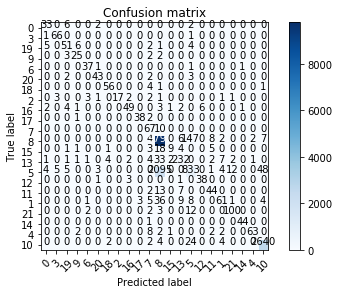

In [18]:
# print metrics and confusion matrix
classes = clf_bow.predict(X_test_bow).round()
print(classification_report(y_test, classes, digits=5))  
plot_confusion_matrix(confusion_matrix(y_test, classes), classes=y.unique()) 

In [23]:
# print feature importances
feature_importance_raw = list(zip(clf_bow.feature_importances_, count_vect.get_feature_names()))
sorted(feature_importance_raw, reverse=True)[0:100]

[(0.11124228606205061, 'revenue'),
 (0.0710458128788468, 'adjustment'),
 (0.05637925395024464, 'medicaid'),
 (0.038578892805792846, 'overhead'),
 (0.03277330624784323, 'dmh'),
 (0.02844351673515924, 'commercial'),
 (0.021506165164456068, 'expense'),
 (0.014903541917319772, 'medicare'),
 (0.012743336195817556, 'vehicle'),
 (0.012723440161384101, 'bad'),
 (0.012656997874563952, 'debt'),
 (0.012044468381315999, 'self'),
 (0.011336000182935232, 'mc'),
 (0.01103834634027647, 'pay'),
 (0.010682106925815137, 'charity'),
 (0.009026717690743303, 'exp'),
 (0.008980930324008294, 'computer'),
 (0.00874423202686169, 'grant'),
 (0.008072920269158415, 'accum'),
 (0.007963102868473562, 'insurance'),
 (0.00754923805423494, 'cstar'),
 (0.00679123700530526, 'cprc'),
 (0.006769554239477554, 'auto'),
 (0.0067516481096954436, 'income'),
 (0.006651443622869142, 'property'),
 (0.0063236264479899044, 'salary'),
 (0.006319352010370083, 'ar'),
 (0.0062392867391016455, 'outside'),
 (0.006140192081709607, 'refund'

## TF-IDF Vectors

In [20]:
# create TF-IDF vectors
tfidf = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf.fit_transform(X_text)

In [21]:
# train classifier on TF-IDF vectors
X_train_tf, X_test_tf, y_train, y_test = train_test_split(X_tfidf, y, stratify=y, test_size=0.3, random_state=1)

clf_tf = ExtraTreesClassifier(n_estimators = 500, n_jobs = 4, random_state = 1)
clf_tf.fit(X_train_tf, y_train)
print("Train accuracy:\t" + str(clf_tf.score(X_train_tf, y_train)))
print("Test accuracy :\t" + str(clf_tf.score(X_test_tf, y_test)))

Train accuracy:	0.8564248196828429
Test accuracy :	0.8443766858215082


             precision    recall  f1-score   support

          0    0.75000   0.83721   0.79121        43
          1    0.89189   0.97059   0.92958        68
          2    0.76119   0.73913   0.75000        69
          3    0.67647   0.71875   0.69697        32
          4    0.88095   0.92500   0.90244        40
          5    0.84314   0.86000   0.85149        50
          6    0.94828   0.88710   0.91667        62
          7    0.84615   0.70968   0.77193        31
          8    0.90000   0.78261   0.83721        69
          9    1.00000   0.95122   0.97500        41
         10    0.58772   0.87013   0.70157        77
         11    0.81767   0.98195   0.89231      9970
         12    0.81250   0.30952   0.44828        42
         13    0.89437   0.86689   0.88042       293
         14    0.80532   0.28173   0.41743      3010
         15    0.82609   0.88372   0.85393        43
         16    0.77586   0.68182   0.72581        66
         17    0.81481   0.51562   0.63158   

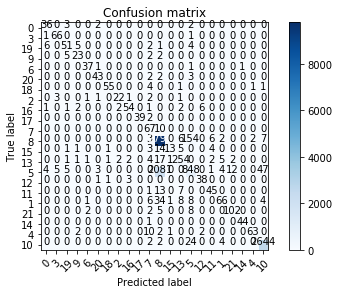

In [22]:
pred = clf_tf.predict(X_test_tf)
classes = pred.round()
print(classification_report(y_test, classes, digits=5))  

cnf_matrix = confusion_matrix(y_test, classes)
plot_confusion_matrix(cnf_matrix, classes=y.unique()) 

## Word2Vec Embeddings

In [64]:
# train word2vec vectors
model_w2v = Word2Vec(X_tokens, size = EMBEDDING_LENGTH)
w2v = {w: vec for w, vec in zip(model_w2v.wv.index2word, model_w2v.wv.syn0)}
print(model_w2v)

Word2Vec(vocab=691, size=300, alpha=0.025)


In [65]:
# example of similarities
model_w2v.most_similar("revenue")

[('medicaid', 0.7022696733474731),
 ('adjustments', 0.6976547837257385),
 ('fqhc', 0.6709210872650146),
 ('ar', 0.6470886468887329),
 ('adjustment', 0.6410227417945862),
 ('nextgen', 0.636593222618103),
 ('provision', 0.636465311050415),
 ('hch', 0.6317830681800842),
 ('wrap', 0.6274222135543823),
 ('debt', 0.6253610849380493)]

### Mean embeddings

In [44]:
# create Mean Embedding vectors
X_w2v = MeanEmbeddingVectorizer(w2v).transform(X_text)

In [26]:
# train classifier on word2vec mean embedding vectors
X_w2v_df = pd.DataFrame(data = X_w2v)
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X_w2v_df, y, stratify=y, test_size=0.3, random_state=1)

clf_w2v = ExtraTreesClassifier(n_estimators = 500, n_jobs = 4, random_state = 1)
clf_w2v.fit(X_train_w2v, y_train)
print("Train accuracy:\t" + str(clf_w2v.score(X_train_w2v, y_train)))
print("Test accuracy:\t" + str(clf_w2v.score(X_test_w2v, y_test)))

Train accuracy:	0.8516247392626474
Test accuracy:	0.837809311598452


             precision    recall  f1-score   support

          0    0.70213   0.76744   0.73333        43
          1    0.78947   0.88235   0.83333        68
          2    0.73913   0.73913   0.73913        69
          3    0.65517   0.59375   0.62295        32
          4    0.78723   0.92500   0.85057        40
          5    0.82609   0.76000   0.79167        50
          6    0.82759   0.77419   0.80000        62
          7    0.70000   0.45161   0.54902        31
          8    0.85714   0.60870   0.71186        69
          9    0.87805   0.87805   0.87805        41
         10    0.91781   0.87013   0.89333        77
         11    0.81515   0.98014   0.89006      9970
         12    0.63158   0.28571   0.39344        42
         13    0.78788   0.79863   0.79322       293
         14    0.80744   0.28140   0.41734      3010
         15    0.85714   0.83721   0.84706        43
         16    0.79245   0.63636   0.70588        66
         17    0.78481   0.48438   0.59903   

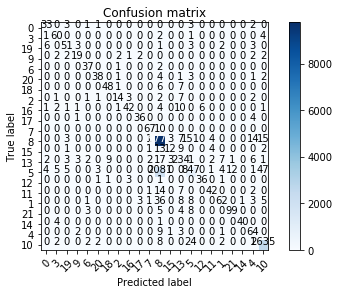

In [27]:
# print metrics and confusion matrix
classes = clf_w2v.predict(X_test_w2v).round()
print(classification_report(y_test, classes, digits=5))  
plot_confusion_matrix(confusion_matrix(y_test, classes), classes=y.unique()) 

### Sequence classification with Word2Vec embeddings

In [46]:
# define length of sequence (go back and use max length of documents) and split data
max_len = 5 
X_train_tokens, X_test_tokens, y_train, y_test = train_test_split(X_tokens, y, stratify=y, test_size=0.3, random_state=1)

# create 3d input volume of [samples, timesteps, features]
X_train_vol = input_volume(model_w2v, X_train_tokens, max_len)
X_test_vol = input_volume(model_w2v, X_test_tokens, max_len)

# create one-hot encoded labels
y_test_encoded = to_categorical(y_test)
y_train_encoded = to_categorical(y_train)

num_classes = df['label'].nunique()

#### LSTM

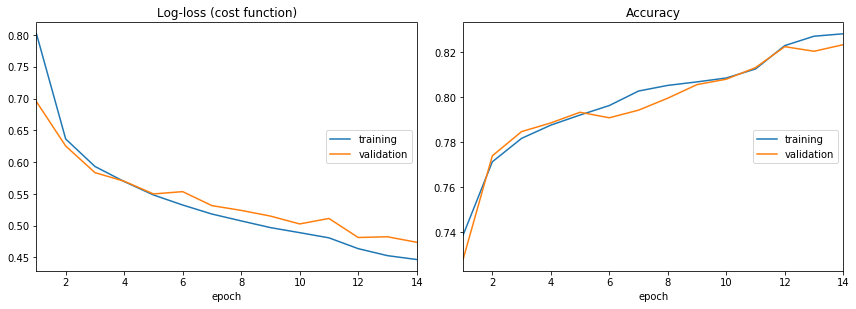

In [36]:
# build LSTM layers and train model - should experiment with layers, hyperparameters, bidirectional LSTM, and 1D CNN
model = Sequential()
model.add(LSTM(100, dropout= 0.2, input_shape=(max_len, EMBEDDING_LENGTH)))
model.add(Activation('relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train_vol, y_train_encoded, validation_data=(X_test_vol, y_test_encoded), epochs=14, batch_size=16,callbacks=[PlotLossesKeras()])

In [37]:
# print accuracy
score_train = model.evaluate(X_train_vol, y_train_encoded)
score_test = model.evaluate(X_test_vol, y_test_encoded)
print("Train accuracy:\t" + str(score_train[1]))
print("Test accuracy:\t" + str(score_test[1]))

17054/17054 [==============================] - 4s 219us/step
Train accuracy:	0.8342590032981936
Test accuracy:	0.8233259059108686


In [38]:
# print classification report
classes = model.predict(X_test_vol).round()
print(classification_report(y_test_encoded, classes, digits=5))  

             precision    recall  f1-score   support

          0    0.85714   0.13953   0.24000        43
          1    0.79412   0.79412   0.79412        68
          2    0.54839   0.24638   0.34000        69
          3    0.52000   0.40625   0.45614        32
          4    0.95833   0.57500   0.71875        40
          5    0.86364   0.38000   0.52778        50
          6    0.73913   0.54839   0.62963        62
          7    0.75000   0.29032   0.41860        31
          8    0.95833   0.66667   0.78632        69
          9    0.82609   0.46341   0.59375        41
         10    0.93333   0.54545   0.68852        77
         11    0.81812   0.96459   0.88534      9970
         12    1.00000   0.07143   0.13333        42
         13    0.81509   0.73720   0.77419       293
         14    0.74007   0.29701   0.42390      3010
         15    0.90244   0.86047   0.88095        43
         16    0.89286   0.37879   0.53191        66
         17    0.83636   0.35938   0.50273   

#### CNN

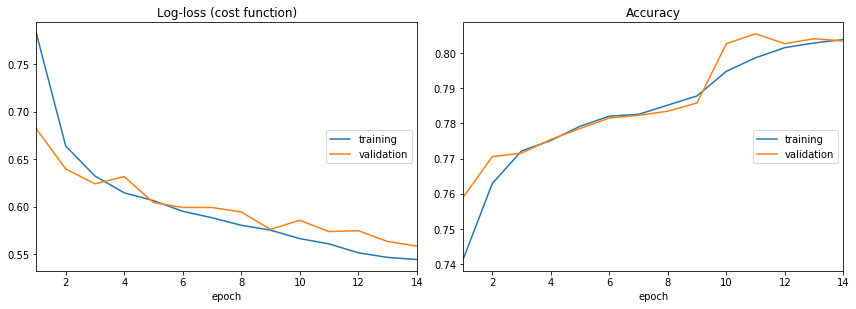

In [66]:
model = Sequential()
model.add(Conv1D(128, 3, activation='relu', input_shape=(max_len, EMBEDDING_LENGTH)))
model.add(MaxPooling1D(2, padding='same'))
model.add(Dropout(0.2))
# model.add(BatchNormalization())

# model.add(Conv1D(128, 3, activation='relu', padding='same'))
# model.add(MaxPooling1D(2, padding='same'))
# model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train_vol, y_train_encoded, validation_data=(X_test_vol, y_test_encoded), epochs=14, batch_size=16,callbacks=[PlotLossesKeras()])

In [67]:
# print accuracy
score_train = model.evaluate(X_train_vol, y_train_encoded)
score_test = model.evaluate(X_test_vol, y_test_encoded)
print("Train accuracy:\t" + str(score_train[1]))
print("Test accuracy:\t" + str(score_test[1]))

17054/17054 [==============================] - 1s 55us/step
Train accuracy:	0.8135005403306784
Test accuracy:	0.8033892341692953


In [68]:
# print classification report
classes = model.predict(X_test_vol).round()
print(classification_report(y_test_encoded, classes, digits=5))  

             precision    recall  f1-score   support

          0    0.66667   0.18605   0.29091        43
          1    0.74000   0.54412   0.62712        68
          2    0.64286   0.26087   0.37113        69
          3    0.53846   0.21875   0.31111        32
          4    0.80000   0.10000   0.17778        40
          5    0.80000   0.16000   0.26667        50
          6    0.72222   0.41935   0.53061        62
          7    0.61111   0.35484   0.44898        31
          8    0.77083   0.53623   0.63248        69
          9    0.64286   0.21951   0.32727        41
         10    0.89744   0.45455   0.60345        77
         11    0.80381   0.96489   0.87702      9970
         12    0.28571   0.04762   0.08163        42
         13    0.75369   0.52218   0.61694       293
         14    0.73211   0.25150   0.37438      3010
         15    0.85714   0.69767   0.76923        43
         16    0.89655   0.39394   0.54737        66
         17    0.57609   0.41406   0.48182   

#### Bidirectional LSTM

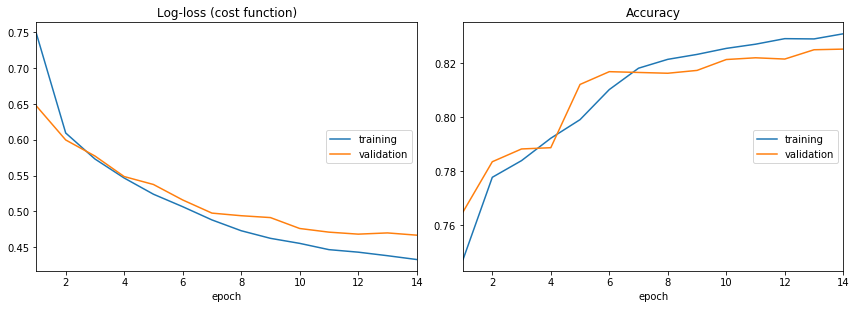

In [53]:
# build LSTM layers and train model - should experiment with layers, hyperparameters, bidirectional LSTM, and 1D CNN
model = Sequential()
model.add(Bidirectional(LSTM(100, dropout= 0.2, input_shape=(max_len, EMBEDDING_LENGTH))))
model.add(Activation('relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())
model.fit(X_train_vol, y_train_encoded, validation_data=(X_test_vol, y_test_encoded), epochs=14, batch_size=16,callbacks=[PlotLossesKeras()])

In [54]:
# print accuracy
score_train = model.evaluate(X_train_vol, y_train_encoded)
score_test = model.evaluate(X_test_vol, y_test_encoded)
print("Train accuracy:\t" + str(score_train[1]))
print("Test accuracy:\t" + str(score_test[1]))

17054/17054 [==============================] - 3s 157us/step
Train accuracy:	0.8359930637671239
Test accuracy:	0.825319573085725


In [55]:
# print classification report
classes = model.predict(X_test_vol).round()
print(classification_report(y_test_encoded, classes, digits=5))  

             precision    recall  f1-score   support

          0    0.91667   0.25581   0.40000        43
          1    0.80645   0.73529   0.76923        68
          2    0.74359   0.42029   0.53704        69
          3    0.73684   0.43750   0.54902        32
          4    0.89189   0.82500   0.85714        40
          5    0.74194   0.46000   0.56790        50
          6    0.72881   0.69355   0.71074        62
          7    0.94444   0.54839   0.69388        31
          8    0.97872   0.66667   0.79310        69
          9    0.75000   0.51220   0.60870        41
         10    0.87719   0.64935   0.74627        77
         11    0.81668   0.96961   0.88660      9970
         12    0.75000   0.07143   0.13043        42
         13    0.80077   0.71331   0.75451       293
         14    0.80219   0.26811   0.40189      3010
         15    0.88095   0.86047   0.87059        43
         16    0.90000   0.40909   0.56250        66
         17    0.80357   0.35156   0.48913   

## Doc2Vec Embeddings

In [39]:
# train doc2vec vectors
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_text)]
model_d2v = Doc2Vec(vector_size=EMBEDDING_LENGTH, window=2, min_count=5, workers=4, iter=100)
model_d2v.build_vocab(documents)
model_d2v.train(documents, total_examples=model_d2v.corpus_count, epochs=model_d2v.iter)
X_d2v = model_d2v.docvecs

In [40]:
# train classifier on Doc2Vec vectors
X_train_d2v, X_test_d2v, y_train, y_test = train_test_split(X_d2v, y, stratify=y, test_size=0.3, random_state=1)

clf_d2v = ExtraTreesClassifier(n_estimators = 500, n_jobs = 4, random_state = 1)
clf_d2v.fit(X_train_d2v, y_train)
print("Train accuracy:\t" + str(clf_d2v.score(X_train_d2v, y_train)))
print("Test accuracy :\t" + str(clf_d2v.score(X_test_d2v, y_test)))

Train accuracy:	1.0
Test accuracy :	0.8929283452562449


             precision    recall  f1-score   support

          0    0.78571   0.25581   0.38596        43
          1    0.92593   0.36765   0.52632        68
          2    0.73077   0.27536   0.40000        69
          3    1.00000   0.25000   0.40000        32
          4    1.00000   0.70000   0.82353        40
          5    0.90000   0.54000   0.67500        50
          6    0.94286   0.53226   0.68041        62
          7    0.00000   0.00000   0.00000        31
          8    0.90909   0.28986   0.43956        69
          9    1.00000   0.63415   0.77612        41
         10    0.97500   0.50649   0.66667        77
         11    0.87312   0.98215   0.92443      9970
         12    0.00000   0.00000   0.00000        42
         13    0.94805   0.49829   0.65324       293
         14    0.90624   0.75781   0.82540      3010
         15    0.86364   0.44186   0.58462        43
         16    0.80952   0.25758   0.39080        66
         17    0.93182   0.32031   0.47674   

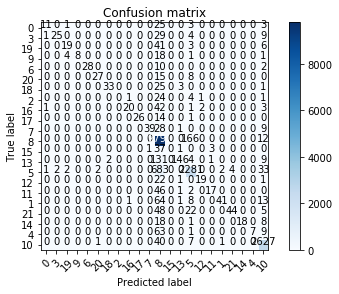

In [41]:
# print metrics and confusion matrix
classes = clf_d2v.predict(X_test_d2v).round()
print(classification_report(y_test, classes, digits=5))  
plot_confusion_matrix(confusion_matrix(y_test, classes), classes=y.unique()) 